In [2]:
from warnings import simplefilter 
simplefilter(action='ignore', category=FutureWarning)
import random
from  keras.preprocessing.image import save_img
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image
import io
import os
import yaml
from Util import *
from IPython import display
import copy
%matplotlib inline

In [3]:
#Global configuration
attackMode = 'Raw' #Raw: means without defense, Detection: With adversarial exmaples detection
queryBudgets = 500 #Query Budgets
random.seed(42) #Set random seeds

rugby_ball: 0.60337645
volleyball: 0.114147484
soccer_ball: 0.07883792
basketball: 0.011759561
knee_pad: 0.007931272
goldfinch: 0.0025414363


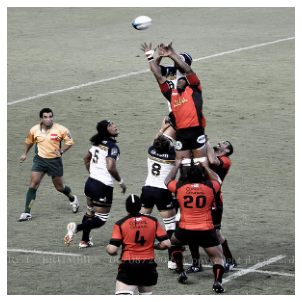

In [4]:
#Select random target image
oriImg= randomimg(mode = attackMode)
display_images(oriImg.img)

  0%|          | 0/500 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Attack result: L2:19.184486420948975, Linf:0.04353711009025574


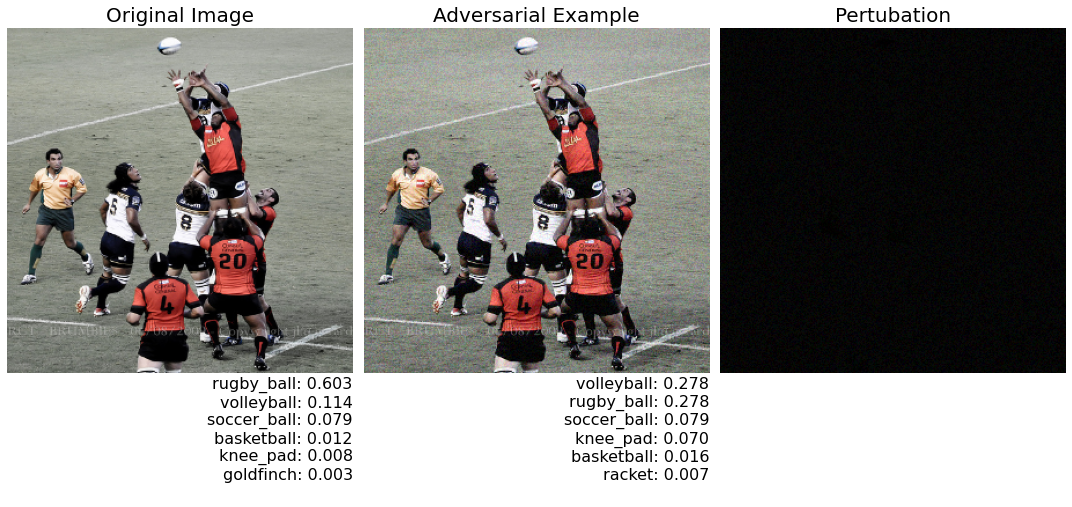

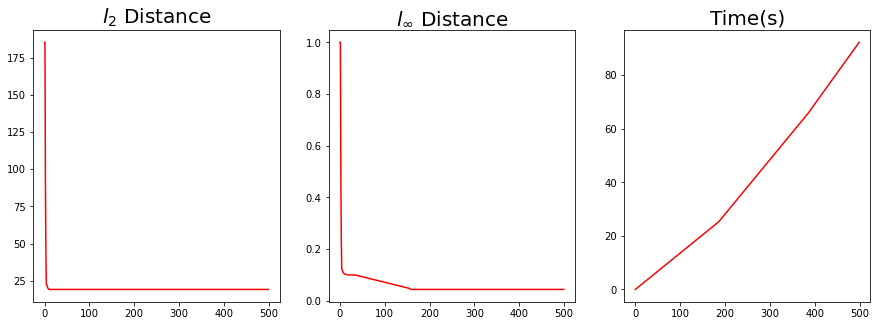

In [5]:
#HJSA attack
from HJSA import hsja
constraint = 'linf'#norm: l2; linf
oriImg_copy = copy.deepcopy(oriImg)
with tf.device('/GPU:0'): 
        timehistory,adversarial = hsja(oriImg_copy,constraint=constraint,
                                                  max_query=queryBudgets,verbose=False)
print('Attack result: L2:{0}, Linf:{1}'.format(oriImg_copy.maxl2,oriImg_copy.maxlinf))
History=[oriImg_copy.historyl2,oriImg_copy.historylinf,timehistory]
DemoVisulization(oriImg_copy.img,adversarial,History,queryBudgets)

  0%|          | 0/500 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Attack result: L2:10.082313537597656, Linf:0.027451038360595703


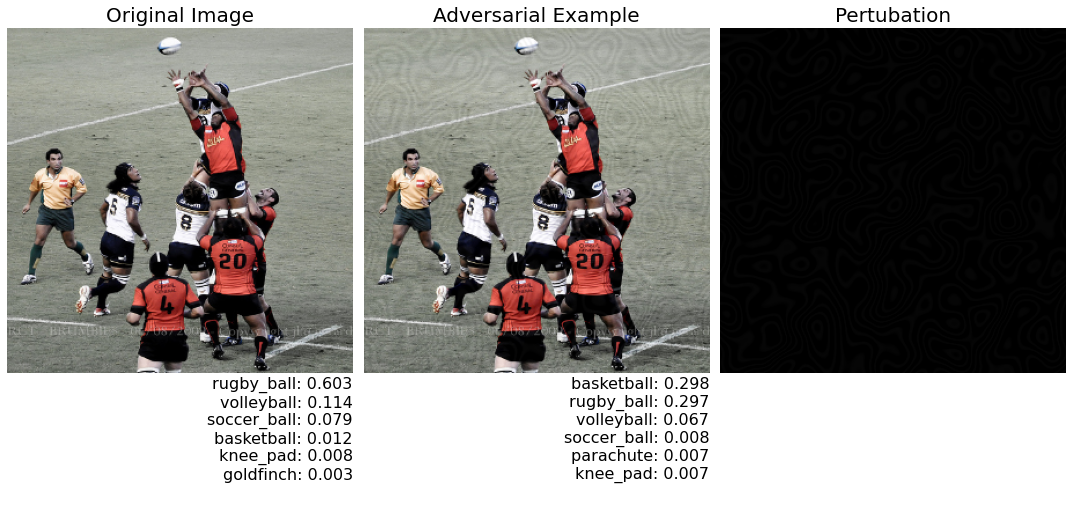

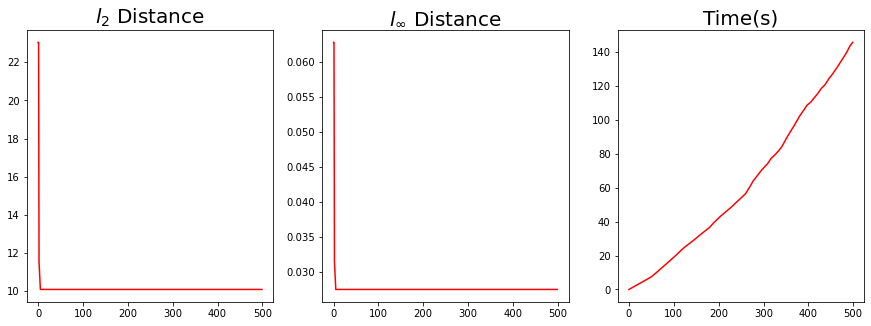

In [6]:
#BO-DBA attack
from BODBA import bayesian_attack
noiseGenerator = 'perlin'#Options: perlin; gabor; BICU; BILI; CLUSTER; NN
constraint = 'linf'#norm: l2; linf
oriImg_copy = copy.deepcopy(oriImg)
with tf.device('/GPU:0'): 
        timehistory,adversarial = bayesian_attack(oriImg_copy,max_query=queryBudgets,
                                                             noise=noiseGenerator,constraint=constraint,init_query=5)
print('Attack result: L2:{0}, Linf:{1}'.format(oriImg_copy.maxl2,oriImg_copy.maxlinf))
History=[oriImg_copy.historyl2,oriImg_copy.historylinf,timehistory]
        
DemoVisulization(oriImg_copy.img,adversarial,History,queryBudgets)

Searching for the initial direction on 100 random directions: 
--------> Found distortion 25.9098
--------> Found distortion 19.8894
--------> Found distortion 19.0936
--------> Found distortion 15.9046
--------> Found distortion 15.0367
--------> Found distortion 15.0138
--------> Found distortion 13.2232
--------> Found distortion 13.0747
==========> Found best distortion 13.0747 in 17.7430 seconds using 312 queries: 319


  0%|          | 0/500 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Attack result: L2:9.198203132441328, Linf:0.08335635249236306


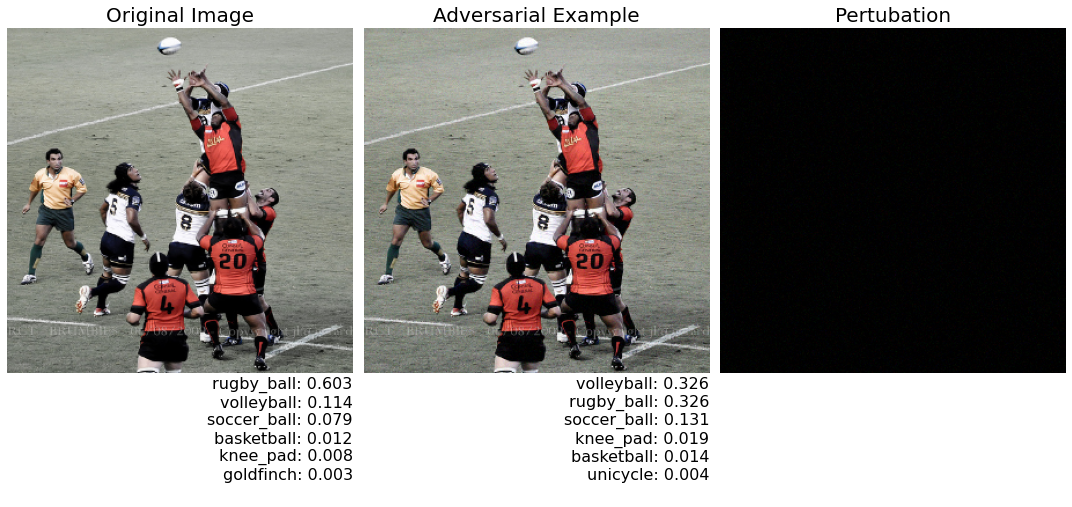

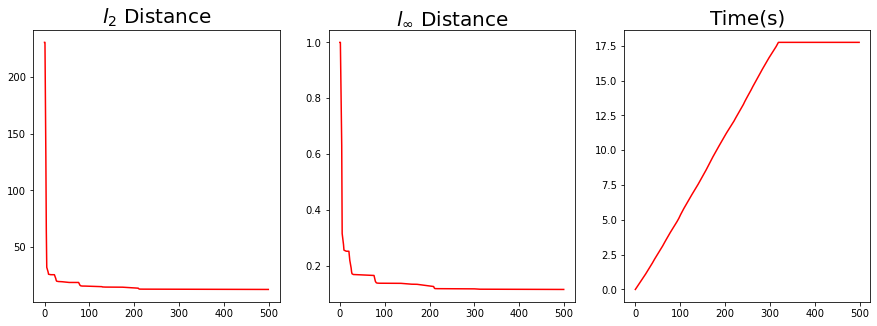

In [7]:
#SignOPT attack
from SignOPT import OPT_attack_sign_SGD
oriImg_copy = copy.deepcopy(oriImg)
attack = OPT_attack_sign_SGD(oriImg_copy)
with tf.device('/GPU:0'):
    timehistory,adversarial=attack.attack_untargeted(query_limit=queryBudgets)
print('Attack result: L2:{0}, Linf:{1}'.format(oriImg_copy.maxl2,oriImg_copy.maxlinf))
History=[oriImg_copy.historyl2,oriImg_copy.historylinf,timehistory]
        
DemoVisulization(oriImg_copy.img,adversarial,History,queryBudgets)

  0%|          | 0/500 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Attack result: L2:58.45979690551758, Linf:0.115883469581604


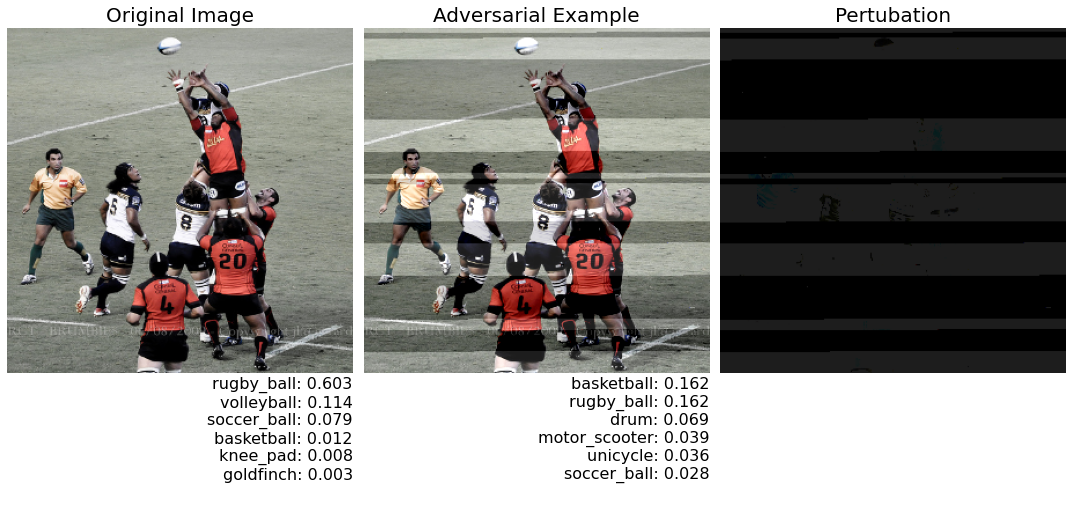

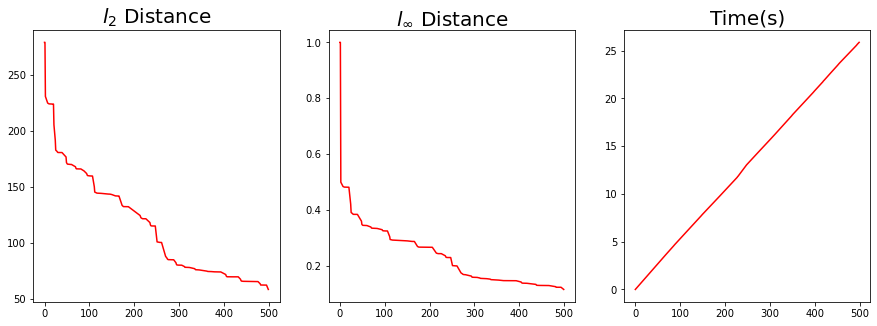

In [8]:
#RayS attack
from RayS import RayS
oriImg_copy = copy.deepcopy(oriImg)
attack = RayS(oriImg_copy,order=np.inf, epsilon=0.3, early_stopping=False)
with tf.device('/GPU:0'):
    timehistory,adversarial=attack.attack_hard_label(query_limit=queryBudgets)
print('Attack result: L2:{0}, Linf:{1}'.format(oriImg_copy.maxl2,oriImg_copy.maxlinf))
History=[oriImg_copy.historyl2,oriImg_copy.historylinf,timehistory]
        
DemoVisulization(oriImg_copy.img,adversarial,History,queryBudgets)